# Water Boiler
This is a description of the Water Boiler reactor - a homogeneous solution of Uranyl(14.7) Sulfate Solution in a hollow stainless steel sphere with a Beryllium Oxide reflector.  

The reactor was used in an experiment at LANL during the Manhattan Project.  The goal of the project was to determine the critical mass of U-235 in a homogeneous solution with various reflectors used.  

A goal of the notebook will be to make extensive use of the Nuclear Data interface of OpenMC for all of the required data.

In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Material Parameters and Calculations

In [2]:
# the mass density of UO2-SO4 solution in water is needed
import scipy.interpolate

def get_UranylSulfate_solution_density(pct_us=0.299,temp=303):
    '''
    input:
    pct_us: float, weight percent UO2-SO4 in water
    temp: float, temperature in K
    
    output:
    rho_us: float, mass density (g/cc) of the solution
    
    This is derived from Table 5 of IEU-SOL-THERM-004
    
    '''
    temp = temp-273.; # convert to C
    y = [0.51, 0.399, 0.299];
    x = [15.,20.,25.,30.,35.,40.,50.];
    
    z = [[1.7959,1.7926,1.7891,1.7854,1.7816,1.777,1.7696],
        [1.5283,1.5257,1.5228,1.5199,1.5166,1.5133,1.5064],
        [1.3499,1.3479,1.3455,1.3430,1.3403,1.3376,1.3314]];
    f = scipy.interpolate.interp2d(x,y,z);
    rho_us = np.float64(f(temp,pct_us));
    return rho_us

In [3]:
# the atomic weight of enriched uranium is needed
def get_Aw_U(enrichment):
    assert (enrichment<=1.0), "enrichment should be entered as a percentage"
    # assumes a fixed ratio in the percentage of U234 and U235.
    # i.e. the enrichment process keeps these two isotopes in the
    # same relative abundance
    
    U234_to_U235_ratio = 0.0055/0.72;
    Aw_U235 = openmc.data.atomic_mass('U235');
    Aw_U234 = openmc.data.atomic_mass('U234');
    Aw_U238 = openmc.data.atomic_mass('U238');
    
    frac_235 = enrichment;
    frac_234 = frac_235*U234_to_U235_ratio;
    frac_238 = 1. - frac_235 - frac_234;
    
    aw = 1./(frac_235/Aw_U235 + frac_238/Aw_U238 + frac_234/Aw_U234);
    
    weight_frac = {};
    weight_frac['U234']=frac_234;
    weight_frac['U235']=frac_235;
    weight_frac['U238']=frac_238;
    
    return aw,weight_frac
    

In [4]:
# calculate atom densities of UO2-SO4 + H2O solution as a function
# of Uranium enrichment, water temperature and Urynal Sulfate concentration

def BoilerAtomDensities(enrich=0.1467,temp=303,conc=0.299):
    ''' 
    input:
    enrich: w/o U-235
    temp: solution temperature in K;
    conc: w/o concentration of Uranyl Sulfate in the water
    
    output:
    dictionary with the atom densities (atoms/b-cm) of all elements
    and nuclides in the solution
    
    this results in a 'not great, not terrible' agreement with the benchmark.
    must re-visit to make corrections
    
    '''
    assert (temp > 288) and (temp < 323), 'temperature not in correlation limits';
    assert (conc >= 0.299) and (conc <= 0.51), 'solution concentration not in correlation limits';
        
    
    Na = 0.60221; # Avagadro's number x10**-24
    AtomDensities = {};
    
    rho_uranyl_sulf_sol = get_UranylSulfate_solution_density(conc,temp);
    rho_water = rho_uranyl_sulf_sol*(1-conc);
    rho_uranyl = rho_uranyl_sulf_sol*conc;
    
    Aw_234 = openmc.data.atomic_mass('U234');
    Aw_235 = openmc.data.atomic_mass('U235');
    Aw_238 = openmc.data.atomic_mass('U238');
    Aw_S = openmc.data.atomic_weight('S');
    Aw_H = openmc.data.atomic_weight('H');
    Aw_O = openmc.data.atomic_weight('O');
    Aw_U,U_weight_fracs = get_Aw_U(enrich);
    
    Aw_uranyl_sulf = Aw_U + 2.*Aw_O + Aw_S + 4.*Aw_O;
    Aw_h2o = 2.*Aw_H + Aw_O;
    
    mol_density_uranyl_sulf = (rho_uranyl/Aw_uranyl_sulf)*Na;
    mol_density_h2o = (rho_water/Aw_h2o)*Na;
    AtomDensities['H']=mol_density_h2o*2.;
    AtomDensities['O']=mol_density_h2o*1.;
    AtomDensities['O']+=mol_density_uranyl_sulf*4.;
    AtomDensities['S']=mol_density_uranyl_sulf*1.;
    AtomDensities['U234']=(mol_density_uranyl_sulf)*U_weight_fracs['U234']; #wrong but better
    AtomDensities['U235']=(mol_density_uranyl_sulf)*U_weight_fracs['U235'];
    AtomDensities['U238']=(mol_density_uranyl_sulf)*U_weight_fracs['U238'];
    
    
    return AtomDensities

### Solution Material

In [5]:
sol_temp = 303; # K, Uranyl Sulfate and water solution temperature
sol_conc = 0.299; # w/o of Uranyl Sulfate in the solution
U_enrch = 0.1467; # w/o enrichment of U235 in Uranyl Sulfate

sol_atom_densities = BoilerAtomDensities(enrich=U_enrch,temp=sol_temp,conc=sol_conc);

sol = openmc.Material(name='sol');
sol.add_element('H',sol_atom_densities['H'],percent_type='ao');
sol.add_element('O',sol_atom_densities['O'],percent_type='ao');
sol.add_element('S',sol_atom_densities['S'],percent_type='ao');
sol.add_nuclide('U234',sol_atom_densities['U234'],percent_type='ao');
sol.add_nuclide('U235',sol_atom_densities['U235'],percent_type='ao');
sol.add_nuclide('U238',sol_atom_densities['U238'],percent_type='ao');
sol.add_s_alpha_beta('c_H_in_H2O');

ad_tot = 0.;
for key in sol_atom_densities:
    ad_tot+=sol_atom_densities[key];

sol.set_density('atom/b-cm',ad_tot);

### Shell Material
I will just use the nuclide and density information from PNNL-15870 Rev. 1 for Steel, Stainless 347.  The composition and atom density for the nominal 347 SS material reported in the benchmark closely match the PNNL data.

In [6]:
shell = openmc.Material(name='shell');
shell.add_element('C',0.003659);
shell.add_element('Si',0.019559);
shell.add_element('P',0.000798);
shell.add_element('S',0.000514);
shell.add_element('Cr',0.179602);
shell.add_element('Mn',0.019998);
shell.add_element('Fe',0.669338);
shell.add_element('Ni',0.102952);
shell.add_element('Nb',0.002365);
shell.add_element('Ta',0.001214);
shell.set_density('g/cc',8.0);

### Beryllium Oxide Reflector
The reported composition and density for the Beryllium Oxide blocks in the benchmark differ *significantly* from PNNL-15870. This is owing to the quick-and-dirty fabrication of the blocks (and associated reduction in material density) as well as the high impurity content.


In [7]:
beryl_ref = openmc.Material(name='beryl_ref');
beryl_ref.add_element('O',6.6210e-2);
beryl_ref.add_element('Be',6.6210e-2);
beryl_ref.add_element('B',3.0637e-7);
beryl_ref.add_element('Co',5.6202e-7);
beryl_ref.add_element('Ag',3.0706e-8);
beryl_ref.add_element('Cd',7.3662e-8);
beryl_ref.add_element('In',1.4423e-8);
beryl_ref.add_s_alpha_beta('c_Be_in_BeO');
beryl_ref.set_density('g/cc',2.75);

### Graphite Base
The beryllium semi-sphere sits in a base of graphite.  No information is given on it's composition. It probably has a trivial impact on the model result but I will just use standard data for graphite

In [8]:
grph = openmc.Material(name='grph');
grph.add_element('C',0.999999);
grph.add_element('B',0.000001);
grph.set_density('g/cc',1.7);
grph.add_s_alpha_beta('c_Graphite');

### Air outside the reactor
I don't really care about the air for its interactions with neutrons; I really just want to include it as a material so I can more fully visualize the geometry.

In [9]:
air = openmc.Material(name='air');
air.add_element('C',0.000150);
air.add_element('N',0.784431);
air.add_element('O',0.210748);
air.add_element('Ar',0.004671);

In [10]:
materials = openmc.Materials([sol,shell,beryl_ref,grph,air]);
materials.export_to_xml();


## Geometry
Create the geometry and plot.  Not too complicated.

### Surfaces

In [11]:
rx_origin = [0.,76.3214,0.];
ref_sphere = openmc.Sphere(y0=rx_origin[1],r=47.4210);
tank_o = openmc.Sphere(y0=rx_origin[1],r=15.3614);
tank_i = openmc.Sphere(y0=rx_origin[1],r=15.282);
graph_base_cyl = openmc.YCylinder(r=47.4210);
fill_drain_cav = openmc.YCylinder(r=4.445/2.);
fill_drain_o = openmc.YCylinder(r=2.06375);
fill_drain_i = openmc.YCylinder(r=1.905);
plate_plane = openmc.YPlane(y0=0.);
base_plane = openmc.YPlane(y0=34.4114);
sphere_center_plane = openmc.YPlane(y0=rx_origin[1]);
upper_plane = openmc.YPlane(y0=118.2314);
bbox = openmc.model.RightCircularCylinder([0.,-10.,0.],140.,60.,axis='y',boundary_type='vacuum');



### Cells

In [12]:
colors = {}
colors[grph]='black';
colors[shell]='silver';
colors[sol]='cadetblue';
colors[beryl_ref]='olive';
colors[air]='lightskyblue';

In [13]:
core = openmc.Cell();
core.fill = sol;
core.region = (-tank_i) | (-fill_drain_i) & -bbox

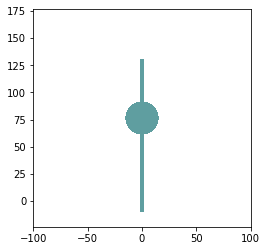

In [14]:

root = openmc.Universe();
root.add_cell(core);

root.plot(origin=rx_origin,width=[200., 200.],pixels=[800,800],
         color_by='material',colors=colors);

In [15]:
steel_tank_and_pipe = openmc.Cell();
steel_tank_and_pipe.fill = shell;
#steel_tank_and_pipe.region = (+tank_i & -tank_o & ~(-fill_drain_i)) | \
#                             (+fill_drain_i & -fill_drain_o & +tank_i) & -bbox
steel_tank_and_pipe.region = (+tank_i & -tank_o & ~(-fill_drain_i)) | \
                             (+fill_drain_i & -fill_drain_o & +tank_i) & -bbox;

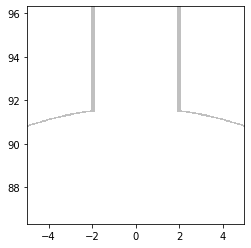

In [16]:
root = openmc.Universe();
root.add_cell(steel_tank_and_pipe);
root.plot(origin=[0.,76.3214+15.,0.],width=[10., 10.],pixels=[400,400],
         color_by='material',colors=colors);
# moved the origin around so the plot can resolve all surface areas in question

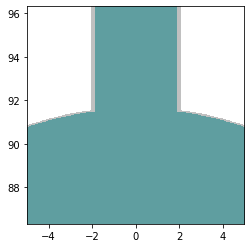

In [17]:
root = openmc.Universe();
root.add_cells([core,steel_tank_and_pipe]);
root.plot(origin=[0.,76.3214+15.,0.],width=[10., 10.],pixels=[400,400],
         color_by='material',colors=colors);
# moved the origin around so the plot can resolve all surface areas in question

In [18]:
ref = openmc.Cell();
ref.fill = beryl_ref;
ref.region = (+tank_o & +fill_drain_o) & -ref_sphere & +base_plane & -upper_plane;

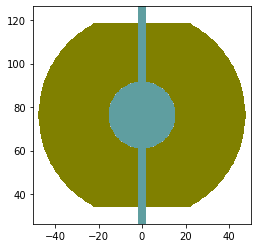

In [19]:
root = openmc.Universe();
root.add_cells([ref,core,steel_tank_and_pipe]);
root.plot(origin=rx_origin,width=[100., 100.],pixels=[400,400],
         color_by='material',colors=colors);

In [20]:
graph_base = openmc.Cell();
graph_base.fill = grph;
graph_base.region = ((-graph_base_cyl & +plate_plane & -base_plane & +fill_drain_o) |
                     (-graph_base_cyl & +ref_sphere & +base_plane & -sphere_center_plane));

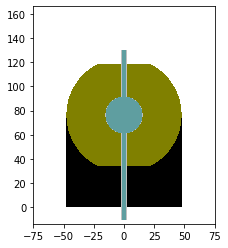

In [21]:
root = openmc.Universe();
root.add_cells([graph_base,ref,core,steel_tank_and_pipe]);
root.plot(origin=rx_origin,width=[150., 180.],pixels=[800,800],
         color_by='material',colors=colors);

In [22]:
outside = openmc.Cell();
outside.fill = air;
outside.region = -bbox & (+graph_base_cyl | (+ref_sphere & -upper_plane) | 
                         (+upper_plane & +fill_drain_o) )

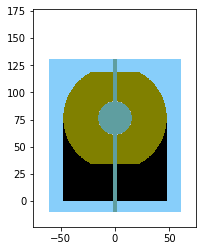

In [23]:
root = openmc.Universe();
root.add_cells([graph_base,ref,core,steel_tank_and_pipe,outside]);
root.plot(origin=rx_origin,width=[150., 200.],pixels=[800,800],
         color_by='material',colors=colors);

In [24]:
geometry = openmc.Geometry();
geometry.root_universe = root;
geometry.export_to_xml();

## Tallies

In [25]:
cell_filter = openmc.CellFilter(core);
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

abs_core = openmc.Tally(name='abs_core');
abs_core.scores = ['absorption'];
abs_core.filters = [cell_filter,energy_filter];

fission = openmc.Tally(name='fission');
fission.scores = ['fission'];
fission.filters = [cell_filter,energy_filter];

fission_by_nuclide = openmc.Tally(name='fission_by_nuclide');
fission_by_nuclide.scores = ['fission'];
fission_by_nuclide.nuclides = ['U234','U235','U238'];
fission_by_nuclide.filters = [cell_filter,energy_filter];

capture = openmc.Tally(name='capture');
capture.scores = ['(n,gamma)'];
capture.filters = [cell_filter,energy_filter];

capture_by_nuclide = openmc.Tally(name='capture_by_nuclide');
capture_by_nuclide.scores = ['(n,gamma)'];
capture_by_nuclide.nuclides = ['U234','U238','H1','O16','S32'];
capture_by_nuclide.filters = [cell_filter,energy_filter];


flux = openmc.Tally(name='flux');
flux.scores = ['flux'];
flux.filters = [cell_filter,energy_filter];

tallies = openmc.Tallies([abs_core, flux,
                          fission, capture,
                          fission_by_nuclide,
                          capture_by_nuclide]);
tallies.export_to_xml();


In [26]:
settings = openmc.Settings();
settings.batches = 800;
settings.inactive = 100;
settings.particles = 25000;

R = 15.;
y_org = 76.3214;

bounds = [-R,-R+y_org,-R,R,R+y_org,R];
uniform_dist = openmc.stats.Box(bounds[:3],bounds[3:],
                                   only_fissionable=True);
settings.source = openmc.source.Source(space=uniform_dist);

#settings.temperature['method']='interpolation';

settings.export_to_xml();

In [27]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

       97/1    1.00683
       98/1    1.00749
       99/1    1.01537
      100/1    1.01882
      101/1    1.00725
      102/1    1.01428    1.01076 +/- 0.00352
      103/1    1.01872    1.01342 +/- 0.00334
      104/1    1.00614    1.01160 +/- 0.00298
      105/1    1.01115    1.01151 +/- 0.00231
      106/1    1.01464    1.01203 +/- 0.00196
      107/1    1.00509    1.01104 +/- 0.00193
      108/1    1.01154    1.01110 +/- 0.00167
      109/1    1.01598    1.01164 +/- 0.00157
      110/1    0.99261    1.00974 +/- 0.00237
      111/1    1.00987    1.00975 +/- 0.00214
      112/1    1.01331    1.01005 +/- 0.00198
      113/1    1.02385    1.01111 +/- 0.00210
      114/1    1.00431    1.01062 +/- 0.00201
      115/1    1.00256    1.01009 +/- 0.00195
      116/1    1.00086    1.00951 +/- 0.00191
      117/1    1.01017    1.00955 +/- 0.00179
      118/1    1.01276    1.00973 +/- 0.00170
      119/1    1.00988    1.00973 +/- 0.00161
      120/1    1.01086    1.00979 +/- 0.00153
      121/1

      278/1    1.01393    1.01008 +/- 0.00060
      279/1    1.01857    1.01012 +/- 0.00060
      280/1    1.03121    1.01024 +/- 0.00061
      281/1    1.01024    1.01024 +/- 0.00061
      282/1    1.01027    1.01024 +/- 0.00060
      283/1    1.00865    1.01023 +/- 0.00060
      284/1    1.02599    1.01032 +/- 0.00060
      285/1    1.01760    1.01036 +/- 0.00060
      286/1    1.02581    1.01044 +/- 0.00060
      287/1    1.00103    1.01039 +/- 0.00060
      288/1    1.02123    1.01045 +/- 0.00060
      289/1    0.99846    1.01038 +/- 0.00060
      290/1    1.02548    1.01046 +/- 0.00060
      291/1    1.02192    1.01052 +/- 0.00060
      292/1    1.01361    1.01054 +/- 0.00060
      293/1    1.02837    1.01063 +/- 0.00060
      294/1    1.00625    1.01061 +/- 0.00060
      295/1    1.00417    1.01058 +/- 0.00060
      296/1    1.01332    1.01059 +/- 0.00060
      297/1    0.99786    1.01053 +/- 0.00060
      298/1    1.00260    1.01049 +/- 0.00060
      299/1    1.00552    1.01046 

      457/1    1.01061    1.01020 +/- 0.00044
      458/1    1.00554    1.01019 +/- 0.00044
      459/1    1.01956    1.01021 +/- 0.00044
      460/1    0.99913    1.01018 +/- 0.00044
      461/1    0.99390    1.01014 +/- 0.00044
      462/1    1.02137    1.01017 +/- 0.00044
      463/1    1.01130    1.01017 +/- 0.00044
      464/1    1.00517    1.01016 +/- 0.00044
      465/1    1.01447    1.01017 +/- 0.00044
      466/1    0.99305    1.01012 +/- 0.00044
      467/1    1.01086    1.01013 +/- 0.00044
      468/1    0.99539    1.01009 +/- 0.00044
      469/1    1.00707    1.01008 +/- 0.00043
      470/1    1.00573    1.01007 +/- 0.00043
      471/1    1.00207    1.01004 +/- 0.00043
      472/1    1.02654    1.01009 +/- 0.00043
      473/1    1.00382    1.01007 +/- 0.00043
      474/1    1.00752    1.01007 +/- 0.00043
      475/1    1.00475    1.01005 +/- 0.00043
      476/1    1.00357    1.01003 +/- 0.00043
      477/1    1.01826    1.01006 +/- 0.00043
      478/1    1.00628    1.01005 

      636/1    0.99381    1.01007 +/- 0.00037
      637/1    1.00077    1.01006 +/- 0.00037
      638/1    0.99831    1.01003 +/- 0.00037
      639/1    1.01549    1.01004 +/- 0.00037
      640/1    1.01576    1.01005 +/- 0.00037
      641/1    1.00894    1.01005 +/- 0.00037
      642/1    1.02092    1.01007 +/- 0.00037
      643/1    0.99711    1.01005 +/- 0.00037
      644/1    1.02502    1.01008 +/- 0.00037
      645/1    1.01946    1.01009 +/- 0.00037
      646/1    1.01320    1.01010 +/- 0.00037
      647/1    1.02413    1.01012 +/- 0.00037
      648/1    1.02453    1.01015 +/- 0.00037
      649/1    1.00220    1.01014 +/- 0.00037
      650/1    1.01283    1.01014 +/- 0.00037
      651/1    0.99830    1.01012 +/- 0.00037
      652/1    1.01055    1.01012 +/- 0.00037
      653/1    1.00767    1.01012 +/- 0.00036
      654/1    0.99804    1.01009 +/- 0.00036
      655/1    1.01102    1.01010 +/- 0.00036
      656/1    1.00296    1.01008 +/- 0.00036
      657/1    1.00371    1.01007 

In [28]:
sp = openmc.StatePoint('statepoint.800.h5');
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	abs_core
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 6: Tally
 	ID             =	6
 	Name           =	flux
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength,
 2: Tally
 	ID             =	2
 	Name           =	fission
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['fission']
 	Estimator      =	tracklength,
 4: Tally
 	ID             =	4
 	Name           =	capture
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['(n,gamma)']
 	Estimator      =	tracklength,
 3: Tally
 	ID             =	3
 	Name           =	fission_by_nuclide
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	U234 U235 U238
 	Scores         =	['fission']
 	Estimator      =	tracklength,
 5: Tally
 	ID             =	5

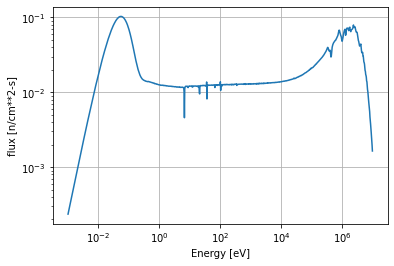

In [29]:
flux = sp.get_tally(name='flux');
flux_df = flux.get_pandas_dataframe();
flux_vals = flux_df['mean'].to_numpy();

energy_x = 0.5*(energy_bins[0:-1] + energy_bins[1:]);

plt.loglog(energy_x,flux_vals);
plt.grid();
plt.xlabel('Energy [eV]');
plt.ylabel('flux [n/cm**2-s]');

Notice the sharp dip in flux at about 10-20 eV.  Presumably this is a resonance absorption peak for something in the core; I'd guess U-238.

The logical nuclide to suspect is U-238 but there is no good reason not to at least look at the other cross sections, so I will import and plot the capture cross sections for all of the isotopes.

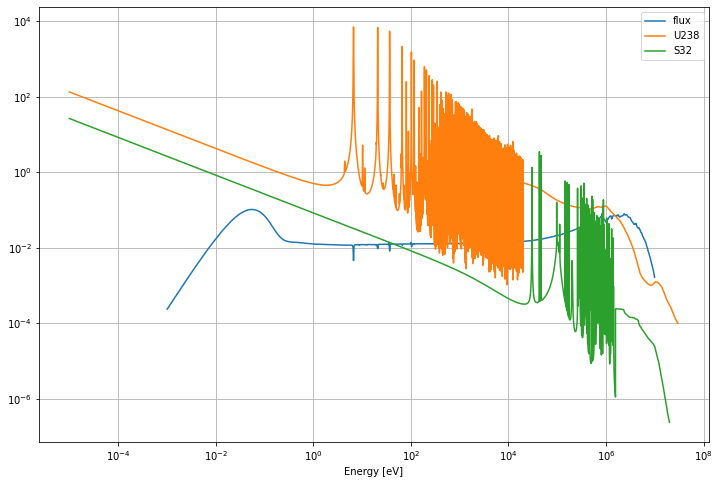

In [30]:
OMC_DATA = "/home/sblair/OMC_DATA/endfb71_hdf5"

u238_path = OMC_DATA + "/U238.h5";
u238 = openmc.data.IncidentNeutron.from_hdf5(u238_path);
u238_capture = u238[102];

s32_path = OMC_DATA + "/S32.h5";
s32 = openmc.data.IncidentNeutron.from_hdf5(s32_path);
s32_capture = s32[102];

plt.rcParams['figure.figsize']=[12,8];
plt.loglog(energy_x,flux_vals,label='flux');
plt.loglog(u238_capture.xs['294K'].x,u238_capture.xs['294K'].y,label='U238');
plt.loglog(s32_capture.xs['294K'].x,s32_capture.xs['294K'].y,label='S32');
plt.grid();
plt.legend();
plt.xlabel('Energy [eV]');



Notice the alignment of the first 3 large resonance peaks of U-238 with the first 3 prominent "dips" in flux.  I plotted S-32 just for reference; I wanted to see the energy at which its resonance region starts.  In general, the resonance region for light isotopes begins at a higher energy than the resonance region for heavy isotopes.  S-32 is the only other isotope besides the Uranium isotopes that has a reasonably high mass number and non-trivial atom density.  

We included U-234 in the model and that must be for a reason.  Let's plot U-234 capture cross section along with U-238 and the flux to see if that might be a contributor.

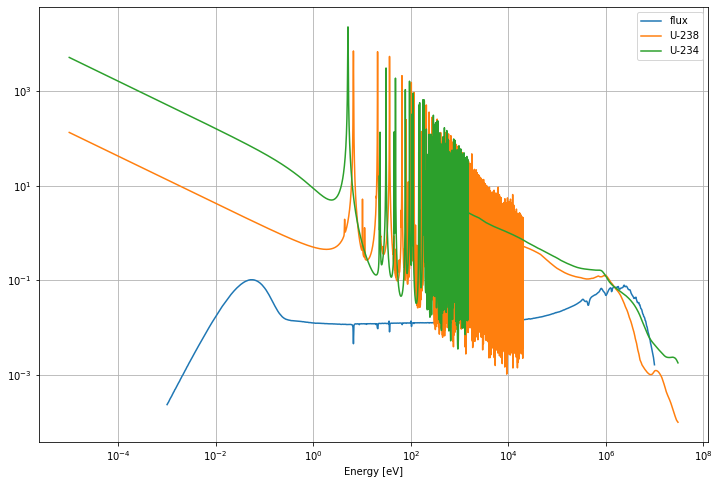

In [31]:
u234_path = OMC_DATA + "/U234.h5";
u234 = openmc.data.IncidentNeutron.from_hdf5(u234_path);
u234_capture = u234[102];

plt.rcParams['figure.figsize']=[12,8];
plt.loglog(energy_x,flux_vals,label='flux');
plt.loglog(u238_capture.xs['294K'].x,u238_capture.xs['294K'].y,label='U-238');
plt.loglog(u234_capture.xs['294K'].x,u234_capture.xs['294K'].y,label='U-234');
plt.grid();
plt.legend();
plt.xlabel('Energy [eV]');

Ahh!  So it turns out that U-234 has an even bigger and lower-lying capture resonance than U-238.  Without a doubt this is why neutron transport models include this (small) isotope.

In [32]:
capture_by_nuclide = sp.get_tally(name='capture_by_nuclide');
capture_by_nuclide_df = capture_by_nuclide.get_pandas_dataframe();

capture_U234 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='U234']['mean'].to_numpy();
capture_U238 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='U238']['mean'].to_numpy();
capture_H1 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='H1']['mean'].to_numpy();
capture_S32 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='S32']['mean'].to_numpy();
capture_O16 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='O16']['mean'].to_numpy();

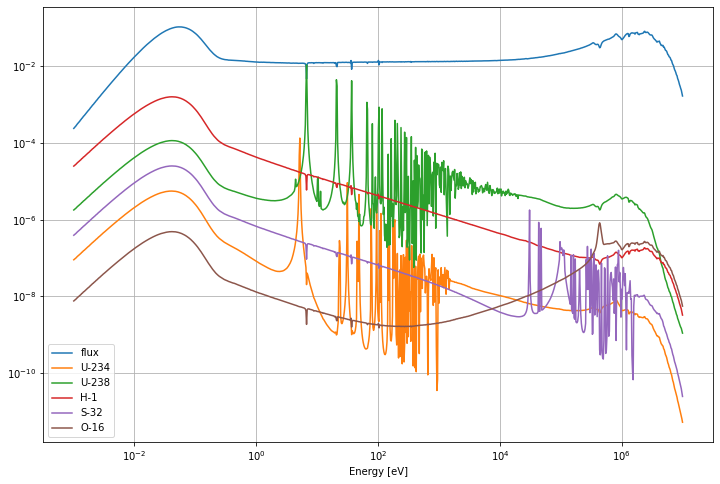

In [34]:
plt.rcParams['figure.figsize']=[12,8];
plt.loglog(energy_x,flux_vals,label='flux');
plt.loglog(energy_x,capture_U234,label='U-234');
plt.loglog(energy_x,capture_U238,label='U-238');
plt.loglog(energy_x,capture_H1,label='H-1');
plt.loglog(energy_x,capture_S32,label='S-32');
plt.loglog(energy_x,capture_O16,label='O-16');
plt.grid();
plt.legend();
plt.xlabel('Energy [eV]');



### Comments for Baseline Case
ven though U-234 has a significant capture cross section, due to its relatively low concentration, the reaction rate is not dominant; it is U-238 instead.  U-238 is also responsible for the flux dips between 10 and 100 eV as well.  

A higher energy - around 1 MeV, it looks like resnances for O-16 and, possibly S-32 become important.  